In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import os
from typing import Tuple, List, Sequence, Callable

In [2]:
df = pd.read_csv('./res/train_df.csv')
df.tail()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
4190,642-2-4-31-Z148_E-0000023.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462
4191,642-2-4-31-Z148_E-0000025.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462
4192,642-2-4-31-Z148_E-0000027.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462
4193,642-2-4-31-Z148_E-0000029.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462
4194,642-2-4-31-Z148_E-0000031.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,762.746552,862.643292,740.504148,890.141117,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462


In [150]:
test = pd.read_csv('./res/sample_submission.csv')

In [77]:
df['x_min'] = df.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df['x_max'] = df.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df['y_min'] = df.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df['y_max'] = df.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

In [78]:
print(df['x_min'].mean())
print(df['x_max'].mean())
print(df['y_min'].mean())
print(df['y_max'].mean())

773.0979737783075
1138.288915375447
414.23289630512517
838.702979737783


In [3]:
row = 0

img1 = tf.io.read_file('./res/train_imgs/' + df['image'][row]) 
img1 = tf.image.decode_jpeg(img1, channels=3)
img1 = img1.numpy()

img2 = tf.io.read_file('./res/train_imgs/' + df['image'][row+1]) 
img2 = tf.image.decode_jpeg(img2, channels=3)
img2 = img2.numpy()

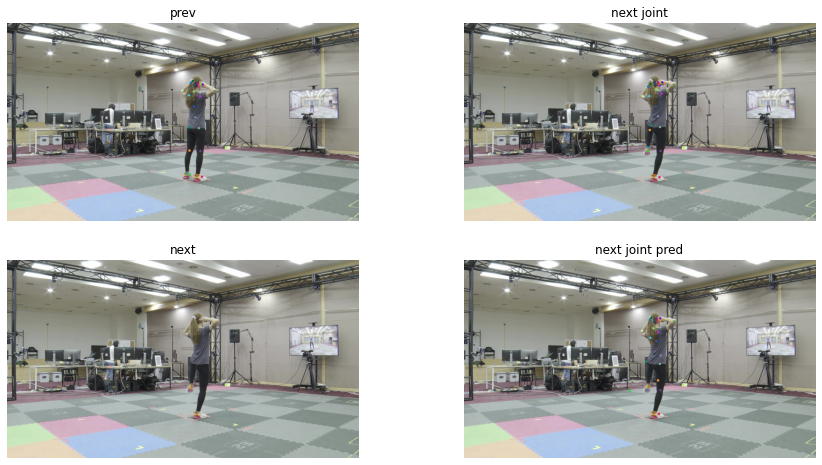

In [4]:
colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

p0 = np.array(df.iloc[row, 1:].values).reshape(-1, 2)
p1 = np.array(df.iloc[row+1, 1:].values).reshape(-1, 2)
p_pred, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, prevPts=p0.astype(np.float32), nextPts=None)

tmp1 = img1.copy()
tmp2 = img2.copy()
tmp3 = img2.copy()

for i, p in enumerate(p0):
    cv2.circle(
        tmp1, 
        tuple(p.astype(int)), 
        3, colors.get(i), thickness=5, lineType=cv2.FILLED)
    
for i, p in enumerate(p1):
    cv2.circle(
        tmp2, 
        tuple(p.astype(int)), 
        3, colors.get(i), thickness=5, lineType=cv2.FILLED)

for i, p in enumerate(p_pred):
    cv2.circle(
        tmp3, 
        tuple(p.astype(int)), 
        3, colors.get(i), thickness=5, lineType=cv2.FILLED)
    
tmp = [tmp1, tmp2, img2, tmp3]
title = ['prev', 'next joint', 'next', 'next joint pred']
fig = plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(tmp[i])
    plt.title(title[i])
    plt.axis('off')
    
plt.show()

In [ ]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train_val_dir + 'train/' + train['image'].iloc[i]) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, [270,480]) 
        img = img/255                         
        
        target = train.iloc[:,1:49].iloc[i,:] 
        target = target/4                     

        yield (img, target)

In [ ]:
def valGenerator():
    for i in range(len(valid)):
        img = tf.io.read_file(train_val_dir + 'val/' + valid['image'].iloc[i]) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, [270,480]) 
        img = img/255                         
        
        target = valid.iloc[:,1:49].iloc[i,:] 
        target = target/4                     

        yield (img, target)

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(batch_size).prefetch(1)
valid_dataset = tf.data.Dataset.from_generator(valGenerator, (tf.float32, tf.float32), (tf.TensorShape([270,480,3]),tf.TensorShape([48])))
valid_dataset = valid_dataset.batch(batch_size).prefetch(1)

In [23]:
inputs = tf.keras.Input((270, 480, 3))
resnet_152V2 = tf.keras.applications.ResNet152V2(
    include_top=False, 
    input_tensor=inputs,
    pooling=None)
x = resnet_152V2.output

# inputs = tf.keras.Input((270, 480, 3))
# resnet_50 = tf.keras.applications.ResNet50(
#     include_top=False, 
#     input_tensor=inputs,
#     pooling=None)
# x = resnet_50.output

In [24]:
x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(filters=48, kernel_size=(86, 134))(x)
outputs = tf.keras.layers.Reshape((-1,))(x)

In [25]:
model = tf.keras.Model(inputs=resnet_152V2.input, outputs=outputs)
# model = tf.keras.Model(inputs=resnet_50.input, outputs=outputs)

In [26]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 270, 480, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 276, 486, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 135, 240, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 137, 242, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

conv4_block5_1_conv (Conv2D)    (None, 17, 30, 256)  262144      conv4_block5_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 17, 30, 256)  1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 17, 30, 256)  0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_pad (ZeroPadding (None, 19, 32, 256)  0           conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 17, 30, 256)  589824      conv4_block5_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_bloc

conv4_block10_2_conv (Conv2D)   (None, 17, 30, 256)  589824      conv4_block10_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block10_2_bn (BatchNormal (None, 17, 30, 256)  1024        conv4_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block10_2_relu (Activatio (None, 17, 30, 256)  0           conv4_block10_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block10_3_conv (Conv2D)   (None, 17, 30, 1024) 263168      conv4_block10_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, 17, 30, 1024) 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________

conv4_block15_preact_relu (Acti (None, 17, 30, 1024) 0           conv4_block15_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 17, 30, 256)  262144      conv4_block15_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 17, 30, 256)  1024        conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 17, 30, 256)  0           conv4_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_2_pad (ZeroPaddin (None, 19, 32, 256)  0           conv4_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv4_block29_1_bn (BatchNormal (None, 17, 30, 256)  1024        conv4_block29_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block29_1_relu (Activatio (None, 17, 30, 256)  0           conv4_block29_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block29_2_pad (ZeroPaddin (None, 19, 32, 256)  0           conv4_block29_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block29_2_conv (Conv2D)   (None, 17, 30, 256)  589824      conv4_block29_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block29_2_bn (BatchNormal (None, 17, 30, 256)  1024        conv4_block29_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block33_out (Add)         (None, 17, 30, 1024) 0           conv4_block32_out[0][0]          
                                                                 conv4_block33_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block34_preact_bn (BatchN (None, 17, 30, 1024) 4096        conv4_block33_out[0][0]          
__________________________________________________________________________________________________
conv4_block34_preact_relu (Acti (None, 17, 30, 1024) 0           conv4_block34_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block34_1_conv (Conv2D)   (None, 17, 30, 256)  262144      conv4_block34_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

conv5_block1_2_pad (ZeroPadding (None, 11, 17, 512)  0           conv5_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_conv (Conv2D)    (None, 9, 15, 512)   2359296     conv5_block1_2_pad[0][0]         
__________________________________________________________________________________________________
conv5_block1_2_bn (BatchNormali (None, 9, 15, 512)   2048        conv5_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_relu (Activation (None, 9, 15, 512)   0           conv5_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_0_conv (Conv2D)    (None, 9, 15, 2048)  2099200     conv5_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_bloc

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanSquaredError()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [63]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mean_squared_error',
              metrics=['mae'])

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=50,
                    callbacks = callbacks)

In [86]:
np.sqrt(1000)

31.622776601683793

In [81]:
class Inception_Residual_block(tf.keras.layers.Layer):
    def __init__(self, input_dim, **kwargs):
        super(Inception_Residual_block, self).__init__(**kwargs)
        self.input_dim = input_dim
        
        self.conv_a1 = tf.keras.layers.Conv2D(filters=self.input_dim//4, kernel_size=1)
        self.bn_a1 = tf.keras.layers.BatchNormalization()
        self.relu_a1 = tf.keras.layers.ReLU()
        
        self.conv_a2 = tf.keras.layers.Conv2D(filters=self.input_dim//4, kernel_size=3, padding='same')
        
        self.conv_b1 = tf.keras.layers.Conv2D(filters=self.input_dim//8, kernel_size=1)
        self.bn_b1 = tf.keras.layers.BatchNormalization()
        self.relu_b1 = tf.keras.layers.ReLU()
        
        self.conv_b2 = tf.keras.layers.Conv2D(filters=self.input_dim//8, kernel_size=3, padding='same')
        self.bn_b2 = tf.keras.layers.BatchNormalization()
        self.relu_b2 = tf.keras.layers.ReLU()
        
        self.conv_b3 = tf.keras.layers.Conv2D(filters=self.input_dim//8, kernel_size=3, padding='same')
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv2D(filters=self.input_dim, kernel_size=1)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.skip_connection = tf.keras.layers.Add()
        self.relu3 = tf.keras.layers.ReLU()
    
    def call(self, inputs):
        skip = inputs
        x1 = self.conv_a1(inputs)
        x1 = self.bn_a1(x1)
        x1 = self.relu_a1(x1)
        x1 = conv_a2(x1)
        
        x2 = self.conv_b1(inputs)
        x2 = self.bn_b1(x2)
        x2 = self.relu_b1(x2)
        x2 = self.conv_b2(x2)
        x2 = self.bn_b2(x2)
        x2 = self.relu_b2(x2)
        x2 = self.conv_b3(x2)
        
        x = self.concat([x1, x2])
        
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.skip_connection([x, skip])
        outputs = self.relu3(x)
        return outputs

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 256))

irb = Inception_Residual_block(256)
irb(inputs)

In [89]:
model.evaluate


In [87]:
os.getcwd()

'C:\\Users\\kwon\\Desktop\\dacon'

In [88]:
np.sqrt(629.8845)

25.097499875485607